In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import sys
import os
sys.path.append(os.path.abspath('helperPix2Pix'))
from generator_model import Generator
from discriminator_model import Discriminator
from trainPix2Pix import train_fn, validate_fn

import config
from dataset import MapDataset


from torch.utils.data import DataLoader
from tqdm import tqdm
import h5py
import random

In [2]:


# Add the parent directory of 'helper' to the Python path
sys.path.append(os.path.abspath(os.path.join('..', '..', 'helper')))

# Now you can import the loader module
import loader

In [3]:
dir = '../../../DeepMIMOv2/DeepMIMO_Data/Static_BS16/freq_symb_1ant_612sub_ver4/Gan_0_dBOutdoor1_3p4_1ant_612subcs_Row_3500_3516.mat'

if os.path.exists(dir) and os.path.isfile(dir):
    print("Directory exists")
else:
    print("Directory does not exist")

Directory exists


In [4]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 10 # 20

# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['3500', '3516']] 
fc = '3p4' #Hz can change to '60'
rowss = "3500_3516"
learning_rate = 1e-5 
outer_file_path = os.path.abspath(os.path.join('..', '..', '..',
                                                'DeepMIMOv2', 'DeepMIMO_Data', 'Static_BS16', 'freq_symb_1ant_612sub_ver4'))


In [5]:
rows = [['3500', '3516']] 
SNR =[0]
snr = 0
fc = '3p4'

norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
    
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    


In [6]:
for snr in SNR:
    print(f" SNR: {snr}/{SNR[-1]}")

    [trainLabels, valLabels], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = loader.load_data(outer_file_path, rows, fc, device, snr)

    # -----------------------------------------------------
    # 1. When input is H_linear (after LS+LI)
    print(f" Training for LS+LI")
    # [samples, 2, 612, 14]
    train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_linear_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
        # train_loader = TensorDataset(data_normd, label_normd, label_x, label_y)
        # data_normd == 612 x 14 x (Nsamples*2)
    val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_linear_val,     valLabels, BATCH_SIZE, device, 'train', False, norm_approach, lower_range=lower_range)
        # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                    # of valLabels
        # train_loader, val_loader are already normalized by their own min, max
        # "train" mode: treat real and image parts as 2 discrete images
        

 SNR: 0/0


/home/thien/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


 Training for LS+LI


In [9]:
disc = Discriminator(in_channels=1).to(config.DEVICE)
gen = Generator(in_channels=1, features=64).to(config.DEVICE)
opt_disc = optim.Adam(disc.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.5, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()


In [10]:
# train_loader = DataLoader(
#     train_dataset,
#     batch_size=config.BATCH_SIZE,
#     shuffle=True,
#     num_workers=config.NUM_WORKERS,
# )

NUM_EPOCHS = 1
validate_generated = []
validate_target = []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch}/{NUM_EPOCHS}: ')
    train_fn(
        disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE
    )
    
    # Validation step
    val_loss, x, y = validate_fn(gen, val_loader, L1_LOSS, BCE)
    validate_generated.append(x.cpu()) 
    validate_target.append(y.cpu()) 
    

Epoch: 0/1: 


100%|██████████| 173/173 [00:19<00:00,  9.04it/s, D_fake=0.283, D_real=0.599]


Validation Loss: 8.0550


In [12]:
(validate_generated)[0].shape

torch.Size([1, 612, 14])

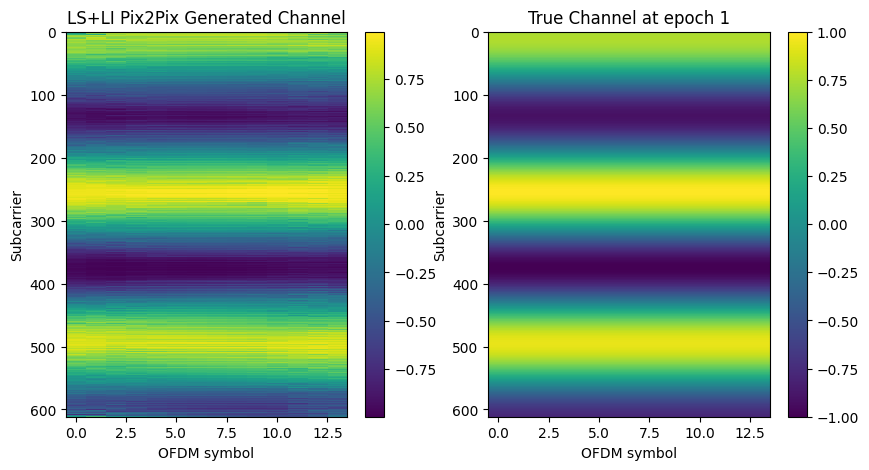

In [19]:
import matplotlib.pyplot as plt
i = 0 # epoch index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(validate_generated[i].permute(1, 2, 0),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title(f'LS+LI Pix2Pix Generated Channel')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(validate_target[i].permute(1, 2, 0),  aspect='auto', cmap='viridis', interpolation='none')
plt.xlabel('OFDM symbol')
plt.ylabel('Subcarrier')
plt.title(f'True Channel at epoch {i+1}')
plt.colorbar()

plt.show()